In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp

### Import raw baseball stats and salaries data

In [2]:
batting_raw = pd.read_csv('Batting.csv')
pitching_raw = pd.read_csv('Pitching.csv')
salaries_raw = pd.read_csv('Salaries.csv')

In [3]:
salaries_raw.head()

,yearID,teamID,lgID,playerID,salary
0,1985,ATL,NL,barkele01,870000
1,1985,ATL,NL,bedrost01,550000
2,1985,ATL,NL,benedbr01,545000
3,1985,ATL,NL,campri01,633333
4,1985,ATL,NL,ceronri01,625000


In [4]:
salaries_raw[salaries_raw['playerID'] == 'barkele01']

,yearID,teamID,lgID,playerID,salary
0,1985,ATL,NL,barkele01,870000
552,1986,ATL,NL,barkele01,880000
1291,1987,ATL,NL,barkele01,890000
1613,1987,ML4,AL,barkele01,72500
1917,1988,ATL,NL,barkele01,900000


### Perform joins between batting stats and salaries, pitching stats and salaries

In [5]:
df_batting = salaries_raw.merge(batting_raw, how='left',on=['playerID', 'yearID'])
df_pitching = salaries_raw.merge(pitching_raw, how='left', on=['playerID', 'yearID'])
df_all = df_batting.append(df_pitching).sort_values(by=['yearID'])

### Create salary vectors for batters, pitchers, and all players

In [6]:
salaries_b = df_batting['salary']
salaries_p = df_pitching['salary']
salaries_all = df_all['salary']

### Summarize distributions of batters, pitchers, and all players

In [7]:
dist_all = salaries_all.describe()
dist_b = salaries_b.describe()
dist_p = salaries_p.describe()

In [8]:
pd.options.display.float_format = '{:,.0f}'.format

dist_summary = pd.DataFrame()
dist_summary['All Players'] = dist_all
dist_summary['Batters'] = dist_b
dist_summary['Pitchers'] = dist_p

In [9]:
dist_summary

,All Players,Batters,Pitchers
count,"56,870","29,119","27,751"
mean,"2,088,687","2,093,820","2,083,301"
std,"3,428,333","3,426,311","3,430,506"
min,0,0,0
25%,"300,000","300,000","300,000"
50%,"575,000","575,000","560,619"
75%,"2,387,500","2,400,000","2,366,667"
max,"33,000,000","33,000,000","33,000,000"


Every summary statistic is similar across all batters, pitchers, and all players. We compare the distributions by using the Kolmogorov-Smirnov test.

### Compare distributions of batters, pitchers, and all players using KS test

Under the KS test, the null hypothesis is that the distributions being compared are the same. If the p-value of the KS test is higher than a significance level a (usually 0.05 or 0.01), then the null hypothesis cannot be rejected and it is highly probable the distributions compared are the same.

In [10]:
# compare batter and pitcher distributions
ks_2samp(salaries_b, salaries_p)

Ks_2sampResult(statistic=0.004640375516441364, pvalue=0.9196232015390564)

In [11]:
# compare batter and all player distributions
ks_2samp(salaries_b, salaries_all)

Ks_2sampResult(statistic=0.0022643759619617176, pvalue=0.9999700892205982)

In [12]:
# compare pitcher and all player distributions
ks_2samp(salaries_p, salaries_all)

Ks_2sampResult(statistic=0.0023759995544796464, pvalue=0.999937038482962)

Looking at all three comparisons (batters vs. pitchers, batters vs. all players, pitchers vs. all players), the p-values are all very large. Therefore, it is highly probable that all three distributions are the same. We adjust for this finding by performing analyses on just the income distribution for all players, since looking at all three distributions would be redundant.

### Visualize how income in the MLB has changed over time

In [13]:
avg_all = df_all.groupby(['yearID']).mean()

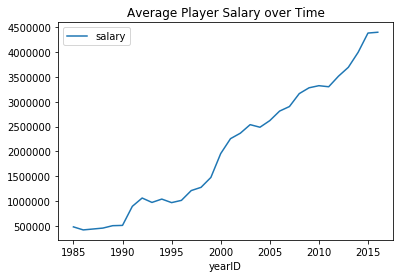

In [53]:
avg_all.plot(y='salary', title = 'Average Player Salary over Time')

### Calculating average annual growth rate in all player salaries

In [9]:
salary1985 = avg_all['salary'].loc[1985]
salary2016 = avg_all['salary'].loc[2016]

In [10]:
total_growth = salary2016 / salary1985
total_growth

9.185254515355856

In [11]:
avg_growth = total_growth**(1/len(avg_all)) - 1
avg_growth

0.07175766907873271

Average income in the MLB has increased constantly, at an annual average growth rate of 7%. This is due to inflation as well as increases in the MLB salary cap over time. Find source

### Comparing annual growth rates to inflation rates

In [12]:
annual_growth = avg_all['salary'].pct_change()
annual_growth = annual_growth.shift(periods=-1).drop([2016])
annual_growth.head()

yearID
1985   -0
1986    0
1987    0
1988    0
1989    0
Name: salary, dtype: float64

In [13]:
inflation = pd.read_csv('united-states-inflation-rate-cpi.csv')
inflation = inflation.set_index('Year')
inflation.head()

,Rate
Year,
1985,0
1986,0
1987,0
1988,0
1989,0


In [14]:
years = np.arange(1985, 2016, 1)
growth = np.asarray(annual_growth)
inflation = np.asarray(inflation)

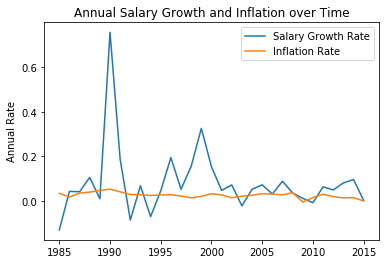

In [15]:
plt.plot(years, annual_growth)
plt.plot(years, inflation)
plt.title('Annual Salary Growth and Inflation over Time')
plt.ylabel('Annual Rate')
plt.legend(('Salary Growth Rate', 'Inflation Rate'),loc='best')
plt.show()

We see that the annual salary growth rate is near the annual inflation rate for most years in the time span of the data we have (1985 - 2016). There are a few years where the salary growth rate is outsized compared to the inflation rate - this can likely be attributed to increases in MLB salary cap.

### Adjusting MLB salary data for inflation

In [155]:
inflation = [inflation[i][0] for i in range(len(inflation))]

In [160]:
df_inf = pd.DataFrame()
df_inf['yearID'] = years
df_inf['rate'] = inflation
df_inf = df_inf.set_index('yearID')

In [191]:
salaries_adj = pd.DataFrame(columns=['yearID', 'playerID', 'salary'])
salaries_adj

,yearID,playerID,salary


In [192]:
for i in range(len(df_all)):
    year = df_all['yearID'].iloc[i]
    player = df_all['playerID'].iloc[i]
    timediff = year - 1985
    temp = df_all['salary'].iloc[i]
    
    if timediff > 0: 
        for j in range((timediff - 1), -1, -1):
            temp = temp / (1 + df_inf['rate'].iloc[j])
            
    tempdf = pd.DataFrame([[year, player, temp]], columns = ['yearID', 'playerID', 'salary'])
    salaries_adj = pd.concat([salaries_adj, tempdf])

In [ ]:
year = df_all['yearID'].iloc[0]
player = df_all['playerID'].iloc[0]
temp = df_all['salary'].iloc[0]
tempdf = pd.DataFrame([[year, player, temp]], columns = ['yearID', 'playerID', 'salary'])
tempdf

In [195]:
salaries_adj

,yearID,playerID,salary
0,1985,barkele01,870000
0,1985,vukovge01,375000
0,1985,thornan01,1100000
0,1985,tablepa01,285000
0,1985,ruhleve01,295000
...,...,...,...
0,2016,parkeja02,"372,551.6270"
0,2016,madsory01,"2,921,973.6909"
0,2016,lowrije01,"3,287,220.2379"
0,2016,vogtst01,"231,201.1567"


In [197]:
# export as csv
salaries_adj.to_csv(r'C:\Users\timfeng\Desktop\Thesis\Code\inflation-adjusted-salaries.csv', 
                    index=False, header=True)

### Calculate inflation adjusted annual growth rates for player salaries

In [14]:
sal_adj = pd.read_csv('inflation-adjusted-salaries.csv')
sal_adj.head()

,yearID,playerID,salary
0,1985,barkele01,"870,000"
1,1985,vukovge01,"375,000"
2,1985,thornan01,"1,100,000"
3,1985,tablepa01,"285,000"
4,1985,ruhleve01,"295,000"


In [15]:
avg_adj = sal_adj.groupby(['yearID']).mean()
avg_adj.head()

,salary
yearID,
1985,"479,249"
1986,"403,611"
1987,"413,537"
1988,"415,853"
1989,"442,124"


In [16]:
sal_adj1985 = avg_adj['salary'].loc[1985]
sal_adj2016 = avg_adj['salary'].loc[2016]

In [17]:
tg_adj = sal_adj2016 / sal_adj1985
tg_adj

4.025860604464634

In [18]:
ag_adj = tg_adj**(1/len(avg_adj)) - 1
ag_adj

0.04448410538754066

Adjusted for inflation, average salary in the MLB increased constantly at an average annual growth rate of ~4.4%.

### Visualize how inflation-adjusted income has changed over time

In [19]:
years = np.arange(1985, 2017, 1)
adj = np.asarray(avg_adj['salary'])
orig = np.asarray(avg_all['salary'])

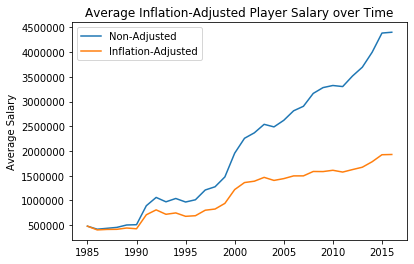

In [20]:
plt.plot(years, orig)
plt.plot(years, adj)
plt.title('Average Inflation-Adjusted Player Salary over Time')
plt.ylabel('Average Salary')
plt.legend(('Non-Adjusted', 'Inflation-Adjusted'),loc='best')
plt.show()

### Summarize and visualize the distribution of inflation-adjusted income

In [21]:
sal2016 = sal_adj[sal_adj['yearID'] == 2016]['salary']

In [22]:
dist_adj = sal2016.describe()
dist_adj

count        1,848
mean     1,929,391
std      2,547,278
min        222,435
25%        228,045
50%        679,359
75%      2,629,776
max     14,463,769
Name: salary, dtype: float64

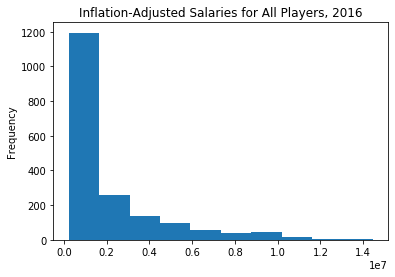

In [23]:
sal2016.plot(kind='hist',title='Inflation-Adjusted Salaries for All Players, 2016')

In [24]:
ba = sal2016[sal2016< dist_adj['mean']]
len(ba)

1270

In [25]:
1270/dist_adj['count']

0.6872294372294372

Next steps

- average of percentiles?
- percentiles over time?
- average of percentiles over time?

### Visualize how each percentile has changed over time

In [26]:
summ_yoy = sal_adj.groupby(['yearID'])['salary'].describe()
summ_yoy.head()

,count,mean,std,min,25%,50%,75%,max
yearID,,,,,,,,
1985,"1,153","479,249","338,697","60,000","210,000","410,000","660,000","2,130,300"
1986,"1,571","403,611","382,879","57,945","85,952","284,899","627,743","2,704,123"
1987,"1,343","413,537","403,741","59,236","80,560","277,223","658,700","2,016,221"
1988,"1,404","415,853","411,445","57,142","94,055","274,280","620,902","2,139,381"
1989,"1,526","442,124","471,850","54,903","80,268","263,533","656,638","2,430,365"


In [27]:
pt0 = summ_yoy['min']
pt25 = summ_yoy['25%']
pt50 = summ_yoy['50%']
pt75 = summ_yoy['75%']
pt100 = summ_yoy['max']

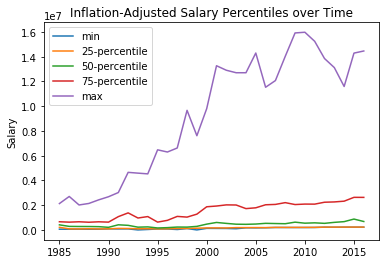

In [28]:
plt.plot(years, pt0)
plt.plot(years, pt25)
plt.plot(years, pt50)
plt.plot(years, pt75)
plt.plot(years, pt100)
plt.title('Inflation-Adjusted Salary Percentiles over Time')
plt.ylabel('Salary')
plt.legend(('min', '25-percentile', '50-percentile', '75-percentile', 'max'),loc='best')
plt.show()

In [29]:
inc0 = pt0.loc[2016]/pt0.loc[1985] - 1 
inc25 = pt25.loc[2016]/pt25.loc[1985] - 1
inc50 = pt50.loc[2016]/pt50.loc[1985] - 1
inc75 = pt75.loc[2016]/pt75.loc[1985] - 1
inc100 = pt100.loc[2016]/pt100.loc[1985] -1

r0 = (inc0 + 1)**(1/len(years)) - 1
r25 = (inc25 + 1)**(1/len(years)) -1
r50 = (inc50 + 1)**(1/len(years)) - 1
r75 = (inc75 + 1)**(1/len(years)) - 1
r100 = (inc100 + 1)**(1/len(years)) - 1

In [30]:
pd.options.display.float_format = '{:,.3f}'.format
increase = pd.DataFrame([[inc0, inc25, inc50, inc75, inc100],[r0, r25, r50, r75, r100] ], 
                        columns=['min', '25%-tile','50%-tile', '75%-tile', 'max'])
increase

,min,25%-tile,50%-tile,75%-tile,max
0,2.707,0.086,0.657,2.985,5.790
1,0.042,0.003,0.016,0.044,0.062


Salaries above the median have improved more drastically than salaries below the median. The increase in max salaries explains the YoY increase in average inflation-adjusted salaries during the same time period.

### Average incomes below median vs. above median

In [31]:
above50 = []
below50 = []

for i in years:
    year_data = sal_adj[sal_adj['yearID'] == i]['salary']
    qt50 = year_data.quantile(0.50)
    above = year_data[year_data > qt50]
    below = year_data[year_data <= qt50]
    
    above50.append(above.mean())
    below50.append(below.mean())

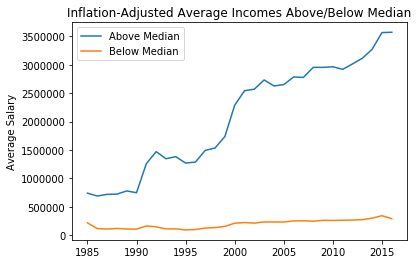

In [32]:
plt.plot(years, above50)
plt.plot(years, below50)
plt.title('Inflation-Adjusted Average Incomes Above/Below Median')
plt.ylabel('Average Salary')
plt.legend(('Above Median', 'Below Median'),loc='best')
plt.show()

In [33]:
inc_below = below50[-1] / below50[0] - 1
inc_above = above50[-1] / above50[0] - 1

r_b = (inc_below + 1)**(1/len(years)) - 1
r_a = (inc_above + 1)**(1/len(years)) - 1

In [34]:
increase2 = pd.DataFrame([[inc_below, inc_above], [r_b, r_a]], 
                        columns=['Avg Below Median', 'Avg Above Median'])
increase2

,Avg Below Median,Avg Above Median
0,0.334,3.822
1,0.009,0.050


The average salary above the median has increased nearly 400%, while the average salary below the median has increased only 33%.

### Calculating current mean salaries between quartiles

In [37]:
sal2016 = sal_adj[sal_adj['yearID'] == 2016]['salary']
qt0 = sal2016.min()
qt25 = sal2016.quantile(0.25)
qt50 = sal2016.quantile(0.50)
qt75 = sal2016.quantile(0.75)
qt100 = sal2016.max()

In [38]:
qt0

222435.2361004395

In [36]:
qt1 = sal2016[sal2016 < qt25]
qt2 = sal2016[(sal2016 >= qt25) & (sal2016 < qt50)]
qt3 = sal2016[(sal2016 >= qt50) & (sal2016 < qt75)]
qt4 = sal2016[sal2016 >= qt75]

In [35]:
n = len(sal2016)

avg1 = qt1.mean()
avg2 = qt2.mean()
avg3 = qt3.mean()
avg4 = qt4.mean()

mult1 = avg1/qt0
mult2 = avg2/qt0
mult3 = avg3/qt0
mult4 = avg4/qt0

ct1 = len(sal2016[sal2016 >= avg1])
ct2 = len(sal2016[sal2016 >= avg2])
ct3 = len(sal2016[sal2016 >= avg3])
ct4 = len(sal2016[sal2016 >= avg4])

pct1 = ct1/n
pct2 = ct2/n
pct3 = ct3/n
pct4 = ct4/n

In [36]:
infer = pd.DataFrame([[avg1, mult1, ct1, pct1],
                      [avg2, mult2, ct2, pct2], 
                      [avg3, mult3, ct3, pct3], 
                      [avg4, mult4, ct4, pct4]], 
                     index=['< 25%-tile', 'Between 25 and 50%-tile','Between 50 and 75%-tile', '>= 75%-tile'],
                     columns=['Avg Income', 'Success Multiple', 'Count Players Above Avg', '% of All Players'])
infer

,Avg Income,Success Multiple,Count Players Above Avg,% of All Players
< 25%-tile,"224,625.69",1.01,1614,0.87
Between 25 and 50%-tile,"356,455.64",1.60,1111,0.60
Between 50 and 75%-tile,"1,512,446.38",6.80,682,0.37
>= 75%-tile,"5,525,695.86",24.84,181,0.10


### Inferring success multiples and probabilities

In [39]:
max_mult = sal2016.max() / sal2016.min()
max_mult

65.0246305418719

In [44]:
sal_min = sal2016.min()
sal_5x = sal_min * 6
sal_10x = sal_min * 11
sal_25x = sal_min * 26
sal_50x = sal_min * 51

In [45]:
x1 = sal2016[sal2016 >= sal_5x]
x2 = sal2016[sal2016 >= sal_10x]
x3 = sal2016[sal2016 >= sal_25x]
x4 = sal2016[sal2016 >= sal_50x]

In [46]:
ct1 = len(x1)
ct2 = len(x2)
ct3 = len(x3)
ct4 = len(x4)

pct1 = ct1/n
pct2 = ct2/n
pct3 = ct3/n
pct4 = ct4/n

In [47]:
infer = pd.DataFrame([[sal_5x, ct1, pct1],
                      [sal_10x, ct2, pct2], 
                      [sal_25x, ct3, pct3], 
                      [sal_50x, ct4, pct4]], 
                     index=['5x', '10x','25x', '50x'],
                     columns=['Income', 'Count Players Above Avg', '% of All Players'])
infer

,Income,Count Players Above Avg,% of All Players
5x,"1,334,611.42",718,0.39
10x,"2,446,787.60",489,0.26
25x,"5,783,316.14",169,0.09
50x,"11,344,197.04",12,0.01
